In [99]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [100]:
%matplotlib inline

In [140]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings

In [141]:
from multicam.mah import get_mah

# Indicator and merger impact

In [103]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [104]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


## Construct indicator for each scale bin, merger ratio

In [105]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [106]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [107]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

In [108]:
# for ii in np.sum(present_mask[0, :], axis=0):
#     print(ii)

## Train MultiCAM on data for cvir

In [121]:
from multicam.models import prepare_datasets, training_suite, tbl_to_arr

In [122]:
rng = np.random.default_rng(seed=42)

In [ ]:
# prepare catalog with all a_m
am_names = [f"am_{ii}" for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])

ma_names = [f"ma_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(ma_peak[:, ii], name=ma_names[ii])

In [124]:
# training data specification
info = {
    "ma": {
        "x": ma_names,
        "y": ('cvir',),
    },
}

# manual as no train/test split
datasets = {
    'ma': {
        'train': (tbl_to_arr(cat, ma_names), tbl_to_arr(cat, ('cvir',))),
        'test': (tbl_to_arr(cat, ma_names), tbl_to_arr(cat, ('cvir',))),
    }
} # same train and test dataset

In [125]:
datasets['ma']['train'][0].shape, datasets['ma']['train'][1].shape

((10000, 165), (10000, 1))

In [126]:
data = {
    "multicam_ma": {
        "xy": datasets["ma"]["train"],
        "n_features": 165,
        "n_targets": 1,
        "model": "linear",
        "kwargs": {"use_multicam": True},
    },
}

In [127]:
models = training_suite(data)
mc = models['multicam_ma']

In [129]:
# get mean cvir and mean predicted cvir for sanity check
cvir_mean = np.mean(cat['cvir'])
cvir_pred_mean = np.mean(mc.predict(datasets['ma']['test'][0]))
np.abs(cvir_mean - cvir_pred_mean) / np.abs(cvir_mean) * 100 # very low error

0.005262648795182711

## Get residuals per scale bin and merger ratio (instantaneous)

In [146]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is cvir
residual_merger = np.zeros((len(Mu), len(scale_bins) - 1))
residual_no_merger = np.zeros((len(Mu), len(scale_bins) - 1))
for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        mask = inst_mask[kk, :, jj].astype(bool)

        if xoff[mask].shape[0] == 0:
            residual_merger[kk, jj] = np.nan
        else: 
            residual_merger[kk, jj] = np.mean( (mc.predict(x[mask]) - y[mask]) / y[mask])

        residual_no_merger[kk, jj] = np.mean( (mc.predict(x[~mask]) - y[~mask]) / y[~mask])

Text(0, 0.5, 'Concentration residual')

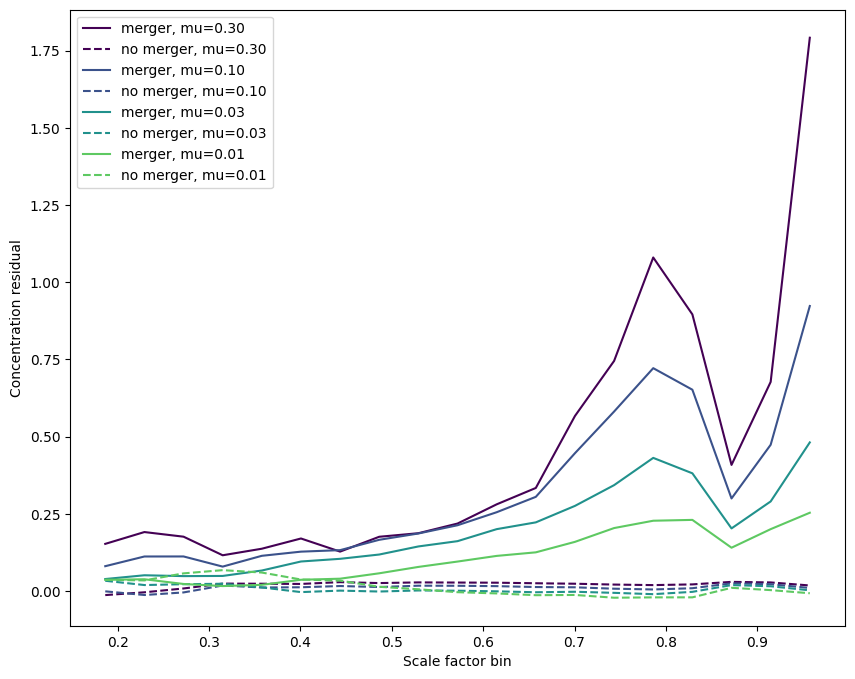

In [153]:
# plot residual vs scale bin for each mu 
plt.figure(figsize=(10, 8))
for kk, mu in enumerate(Mu):
    color = plt.cm.viridis(kk / len(Mu))
    lmu = mu / ( 1- mu)
    plt.plot(scale_bins[:-1], residual_merger[kk], label=f'merger, mu={lmu:.2f}', color=color)
    plt.plot(scale_bins[:-1], residual_no_merger[kk], label=f'no merger, mu={lmu:.2f}', color=color, linestyle='--')
plt.legend()
plt.xlabel('Scale factor bin')
plt.ylabel('Concentration residual')

## Get residuals per scale bin and merger ratio (present)

In [143]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is cvir
residual_merger_pres = np.zeros((len(Mu), len(scale_bins) - 1))
residual_no_merger_pres = np.zeros((len(Mu), len(scale_bins) - 1))
for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        mask = present_mask[kk, :, jj].astype(bool)

        if xoff[mask].shape[0] == 0:
            residual_merger_pres[kk, jj] = np.nan
        else: 
            residual_merger_pres[kk, jj] = np.mean( (mc.predict(x[mask]) - y[mask]) / y[mask])

        residual_no_merger_pres[kk, jj] = np.mean( (mc.predict(x[~mask]) - y[~mask]) / y[~mask])

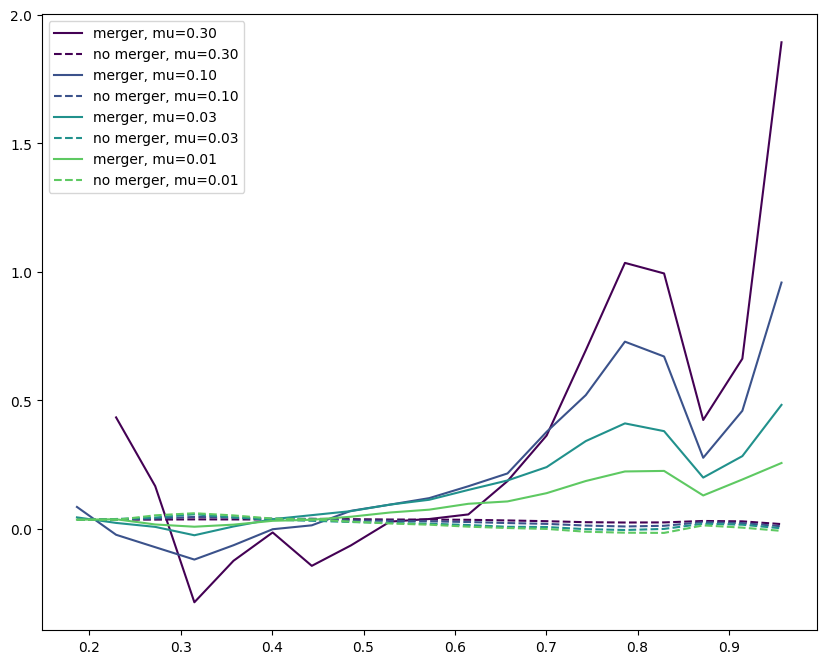

In [154]:
# plot residual vs scale bin for each mu 
plt.figure(figsize=(10, 8))
for kk, mu in enumerate(Mu):
    color = plt.cm.viridis(kk / len(Mu))
    lmu = mu / ( 1- mu)
    plt.plot(scale_bins[:-1], residual_merger_pres[kk], label=f'merger, mu={lmu:.2f}', color=color)
    plt.plot(scale_bins[:-1], residual_no_merger_pres[kk], label=f'no merger, mu={lmu:.2f}', color=color, linestyle='--')
plt.legend()

In [155]:
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])